In [ ]:
# personal DP 
'''DP workflow
    1. create env(discretization)
    2. define agent with state, action space(Policy), cost function(Value: remaining cost of reaching the goal)
    3. Calculate the value function with policy evaluation by backward
    3. start from the final state and propagate backward to the initial state with recursive iteration
    4. store minimum cost and minimum control input for each state

    Caution!
    - global optimum should be selected by searching for local optimum recursively
    - what we have to do is set the range of deciding whether the current state is optimal or not -> because whole time step(episode) is 200, we can check by one time step
    - boundary condition could be very complicated when we have very small time step.
'''
import gymnasium as gym
import sys
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
class PendulumDiscretizer:
    def __init__(self, n_theta=20, n_theta_dot=20, n_action=9, theta_dot_max=8.0, u_max=2.0):
        self.n_theta = n_theta
        self.n_theta_dot = n_theta_dot
        self.n_action = n_action
        self.theta_dot_max = theta_dot_max
        self.u_max = u_max

        # bins for discretization
        self.theta_bins = np.linspace(-np.pi, np.pi, n_theta)
        self.theta_dot_bins = np.linspace(-theta_dot_max, theta_dot_max, n_theta_dot)
        self.action_bins = np.linspace(-u_max, u_max, n_action)

    def encode_state(self, state):
        # recover theta from sin and cos
        theta = np.arctan2(state[0], state[1])
        theta_dot = state[2]

        # discretize
        theta_idx = np.digitize(theta, self.theta_bins) - 1
        theta_dot_idx = np.digitize(theta_dot, self.theta_dot_bins) - 1

        # clip to valid range
        theta_idx = np.clip(theta_idx, 0, self.n_theta - 1)
        theta_dot_idx = np.clip(theta_dot_idx, 0, self.n_theta_dot - 1)

        return (theta_idx, theta_dot_idx)

    def decode_state(self, idx):
        theta_val = self.theta_bins[idx[0]]
        theta_dot_val = self.theta_dot_bins[idx[1]]
        return np.array([np.sin(theta_val), np.cos(theta_val), theta_dot_val])

    def encode_action(self, u):
        u_idx = np.digitize(u, self.action_bins) - 1
        u_idx = np.clip(u_idx, 0, self.n_action - 1)
        return u_idx

    def decode_action(self, idx):
        return np.array([self.action_bins[idx]])


In [ ]:
discretizer = PendulumDiscretizer()

# 예시 상태와 액션
x = np.array([np.sin(np.pi / 3), np.cos(np.pi / 3), 1.0])
u = 0.7

# 이산화
x_idx = discretizer.encode_state(x)
u_idx = discretizer.encode_action(u)

# 복원
x_decoded = discretizer.decode_state(x_idx)
u_decoded = discretizer.decode_action(u_idx)

print("Encoded State:", x_idx)
print("Decoded State:", x_decoded) # [sin(theta), cos(theta), theta_dot]
print("Encoded Action:", u_idx)
print("Decoded Action:", u_decoded)


Encoded State: (12, 10)
Decoded State: [0.73572391 0.67728157 0.42105263]
Encoded Action: 2
Decoded Action: [0.]


In [29]:
import numpy as np
import matplotlib.pyplot as plt

class PendulumDiscretizer:
    def __init__(self,
                 n_theta=42,
                 n_theta_dot=42,
                 n_action=18,
                 theta_dot_max=8.0,
                 u_max=2.0,
                 dt=0.05):
        self.n_theta = n_theta
        self.n_theta_dot = n_theta_dot
        self.n_action = n_action
        self.theta_dot_max = theta_dot_max
        self.u_max = u_max
        self.dt = dt

        # define bins for discretization
        self.theta_bins = np.linspace(-np.pi, np.pi, n_theta)
        self.theta_dot_bins = np.linspace(-theta_dot_max, theta_dot_max, n_theta_dot)
        self.action_bins = np.linspace(-u_max, u_max, n_action)

    def encode_state(self, state):
        """encode continuous state (θ, θ̇) to discrete indices"""
        theta, theta_dot = state
        i = np.digitize(theta, self.theta_bins) - 1
        j = np.digitize(theta_dot, self.theta_dot_bins) - 1
        i = np.clip(i, 0, self.n_theta - 1)
        j = np.clip(j, 0, self.n_theta_dot - 1)
        return (i, j)

    def decode_state(self, idx):
        """decode discrete indices to continuous state (θ, θ̇)"""
        theta = self.theta_bins[idx[0]]
        theta_dot = self.theta_dot_bins[idx[1]]
        return theta, theta_dot

    def decode_action(self, a_idx):
        """decode discrete torque index to continuous torque value"""
        return np.clip(self.action_bins[a_idx], -self.u_max, self.u_max)

def next_state(theta, theta_dot, torque, dt):
    """
    Pendulum-v1 mechanics:
      θ̈ = -3·g·sin(θ+π)/(2L) + 3·torque
      g=9.80665, L=1
    """
    g = 9.80665
    theta_dd = -3 * g * np.sin(theta + np.pi) / 2 + 3 * torque
    theta_new = theta + theta_dot * dt
    theta_dot_new = theta_dot + theta_dd * dt
    return theta_new, theta_dot_new

def cost_fn(theta, theta_dot, torque):
    """cost function"""
    return theta**2 + 0.1 * theta_dot**2 + 0.001 * torque**2

def policy_evaluation(d, policy, V, gamma=0.95, tol=1e-4):
    """Policy Evaluation"""
    while True:
        delta = 0.0
        V_new = V.copy()
        for i in range(d.n_theta):
            for j in range(d.n_theta_dot):
                θ, θ̇ = d.decode_state((i, j))
                a_idx = policy[i, j]
                u = d.decode_action(a_idx)
                θ2, θ̇2 = next_state(θ, θ̇, u, d.dt)
                ni, nj = d.encode_state((θ2, θ̇2))
                r = cost_fn(θ, θ̇, u)
                V_new[i, j] = r + gamma * V[ni, nj]
                delta = max(delta, abs(V_new[i, j] - V[i, j]))
        V = V_new
        if delta < tol:
            break
    return V

def policy_iteration(d, gamma=0.95, tol=1e-4, max_iters=200, cost_tol=1e-3):
    """Policy Iteration"""
    V = np.zeros((d.n_theta, d.n_theta_dot))
    policy = np.zeros((d.n_theta, d.n_theta_dot), dtype=int)
    costs = [] 

    for episode in range(max_iters):
        # 1) Policy evaluation
        print(f"Iteration {episode+1}/{max_iters}")
        V = policy_evaluation(d, policy, V, gamma, tol)

        # 2) Policy improvement
        print("Policy Improvement")
        policy_stable = True
        for i in range(d.n_theta):
            for j in range(d.n_theta_dot):
                θ, θ̇ = d.decode_state((i, j))
                old_a = policy[i, j]

                # Calculate the cost for each action and find the best action
                action_costs = []
                for a_idx in range(d.n_action):
                    u = d.decode_action(a_idx)
                    θ2, θ̇2 = next_state(θ, θ̇, u, d.dt)
                    ni, nj = d.encode_state((θ2, θ̇2))
                    r = cost_fn(θ, θ̇, u)
                    action_costs.append(r + gamma * V[ni, nj])

                best_a = int(np.argmin(action_costs))
                if best_a != old_a:
                    policy_stable = False
                policy[i, j] = best_a

        # 3) Calculate average cost
        print("Calculating average cost")
        total = 0.0
        for i in range(d.n_theta):
            for j in range(d.n_theta_dot):
                θ, θ̇ = d.decode_state((i, j))
                u = d.decode_action(policy[i, j])
                total += cost_fn(θ, θ̇, u)
        avg = total / (d.n_theta * d.n_theta_dot)
        costs.append(avg)

        print(f"[Iter {episode+1}] avg_cost={avg:.6f}, policy_stable={policy_stable}")
        if avg < cost_tol:
            print(f"Stopped: avg_cost < {cost_tol}")
            break

    return V, policy, costs


In [30]:

if __name__ == "__main__":
    # 1) 환경 이산화 및 DP 실행
    disc = PendulumDiscretizer()
    V, policy, cost_hist = policy_iteration(disc)


Iteration 1/200
Policy Improvement
Calculating average cost
[Iter 1] avg_cost=5.688795, policy_stable=False
Iteration 2/200
Policy Improvement
Calculating average cost
[Iter 2] avg_cost=5.688748, policy_stable=False
Iteration 3/200
Policy Improvement
Calculating average cost
[Iter 3] avg_cost=5.688770, policy_stable=False
Iteration 4/200
Policy Improvement
Calculating average cost
[Iter 4] avg_cost=5.688778, policy_stable=False
Iteration 5/200
Policy Improvement
Calculating average cost
[Iter 5] avg_cost=5.688781, policy_stable=False
Iteration 6/200
Policy Improvement
Calculating average cost
[Iter 6] avg_cost=5.688781, policy_stable=False
Iteration 7/200
Policy Improvement
Calculating average cost
[Iter 7] avg_cost=5.688779, policy_stable=False
Iteration 8/200
Policy Improvement
Calculating average cost
[Iter 8] avg_cost=5.688778, policy_stable=False
Iteration 9/200
Policy Improvement
Calculating average cost
[Iter 9] avg_cost=5.688780, policy_stable=False
Iteration 10/200
Policy Impr

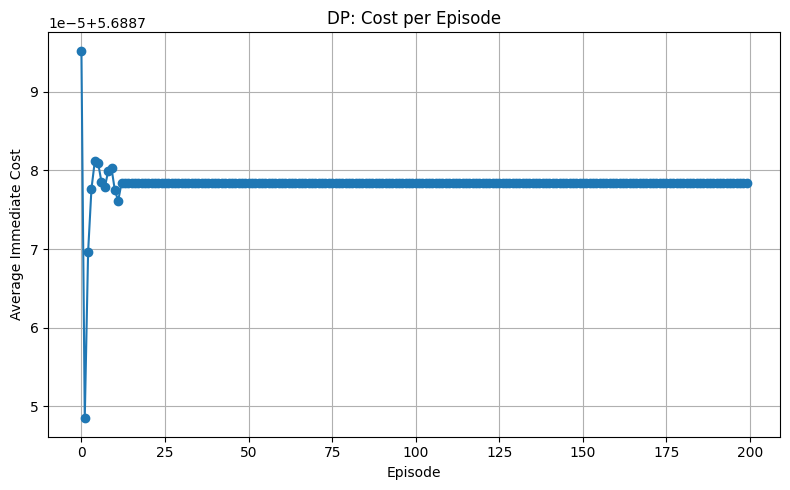

In [31]:
# 2) 결과 플롯
plt.figure(figsize=(8,5))
plt.plot(cost_hist, marker='o')
plt.xlabel("Episode")
plt.ylabel("Average Immediate Cost")
plt.title("DP: Cost per Episode")
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:
from time import time
import logging
import numpy as np
from numpy.linalg import inv
import sympy as sym
from sympy import lambdify

from collections.abc import Callable
from numpy.typing import ArrayLike


class DDPOptimizer:
    """Finite horizon Discrete-time Differential Dynamic Programming(DDP)"""

    def __init__(
        self,
        Nx: int,
        Nu: int,
        dynamics: Callable,
        inst_cost: Callable,
        terminal_cost: Callable,
        tolerance: float = 1e-5,
        max_iters: int = 200,
        with_hessians: bool = False,
        constrain: bool = False,
        alphas: ArrayLike = [1.0],
    ):
        """
        Instantiates a DDP Optimizer and pre-computes the dynamics
        and cost derivates without doing any optimization/solving.

        :param Nx: dimension of the state variable x
        :param Nu: dimension of the control variable u
        :param dynamics: a callable dynamics function with 3 arguments
            x, u, constrain. This function must be closed-form differentiable
            by sympy. In other words, it must be built with sympy and/or numpy.
            Has to return the next state x' with same dimensions as input state.
        :param inst_cost: instantenious (aka running) cost funciton. Must be a
            callable function with 3 arguments x, u, x_goal. Again, must be
            closed-form differentiatable by sympy.
        :param term_cost: terminal cost funciton. Must be a
            callable function with 3 arguments x, u, x_goal. Again, must be
            closed-form differentiatable by sympy.
        :param tolerance: tolerance for convergence. Since DDP does multiple
            runs to optimize a trajectory, we add a tolerance at which optimizing
            further doesn't gain us benfits.
        :param max_iters: maximum number of optimization iterations to perform
        :param with_hessians: if true, does the complete DDP optimization including
            the hessians of the dynamics. This is the complete form of the original
            algorithm but often the computational cost of computing these hessians
            are not worth convergence rate increase.
        :param constrain: whether to constrain the dynamics
        :param alphas: list of backtracking coefficients. Must be <=0 and in
            decreasing order. The length of the list designates the number
            of backtracking attempts. A common configuration is
            `1.1 ** (-np.arange(10) ** 2)`. Backtracking often helps but
            is not necessary to obtain good solutions. To not use backtracking
            just leave at default [1.0]
        """
        assert tolerance > 0
        assert max_iters > 0

        self.Nx = Nx
        self.Nu = Nu
        self.tolerance = tolerance
        self.max_iters = max_iters
        self.with_hessians = with_hessians
        self.constrain = constrain
        self.alphas = alphas

        # Pre-compute derivatives now so that we don't have to do it every time
        x = sym.symbols("x:{:}".format(Nx))
        x = sym.Matrix([xi for xi in x])
        u = sym.symbols("u:{:}".format(Nu))
        u = sym.Matrix([ui for ui in u])
        x_goal = sym.symbols("x_g:{:}".format(Nx))
        x_goal = sym.Matrix([xi for xi in x_goal])

        # dynamics
        self.f = lambdify((x, u), dynamics(x, u, constrain))
        self.fx = lambdify((x, u), dynamics(x, u, constrain).jacobian(x))
        self.fu = lambdify((x, u), dynamics(x, u, constrain).jacobian(u))
        jac = dynamics(x, u).jacobian(x)
        self.fxx = lambdify((x, u), [jac.row(i).jacobian(x) for i in range(Nx)])
        jac = dynamics(x, u).jacobian(u)
        self.fux = lambdify((x, u), [jac.row(i).jacobian(x) for i in range(Nx)])
        jac = dynamics(x, u).jacobian(u)
        self.fuu = lambdify((x, u), [jac.row(i).jacobian(u) for i in range(Nx)])

        # costs
        self.g = lambdify((x, u, x_goal), inst_cost(x, u, x_goal))
        self.gx = lambdify((x, u, x_goal), inst_cost(x, u, x_goal).jacobian(x))
        self.gu = lambdify((x, u, x_goal), inst_cost(x, u, x_goal).jacobian(u))
        self.gxx = lambdify(
            (x, u, x_goal), inst_cost(x, u, x_goal).jacobian(x).jacobian(x)
        )
        self.gux = lambdify(
            (x, u, x_goal), inst_cost(x, u, x_goal).jacobian(u).jacobian(x)
        )
        self.guu = lambdify(
            (x, u, x_goal), inst_cost(x, u, x_goal).jacobian(u).jacobian(u)
        )
        self.h = lambdify((x, x_goal), terminal_cost(x, x_goal))
        self.hx = lambdify((x, x_goal), terminal_cost(x, x_goal).jacobian(x))
        self.hxx = lambdify(
            (x, x_goal), terminal_cost(x, x_goal).jacobian(x).jacobian(x)
        )

    def optimize(
        self,
        x0: ArrayLike,
        x_goal: ArrayLike,
        N: int = None,
        U0: ArrayLike = None,
        full_output: bool = False,
    ):
        """
        Optimize a trajectory given a starting state and a goal state.
        Optimization is performed until convergence or until we run out
        of the maximum number of iterations. If the latter happesn, that
        means that the trajectory is suboptimal and there likely is something
        wrongly configured.
        Note that the lenght of the trajectory is decided based on the args.

        :param x0: starting state. Must be of dimensions (Nx,1)
        :param x_goal: goal state. Must be of dimensions (Nx,1)
        :param N: trajectory lenght. If provided, the optimizer generates
            a random initial control sequence. This is called "slow start"
            and often results in poor optimization time (>1s)
        :param U0: initial control sequence. Must be of dimensions (N,Nu)
            where the N is the implied trajectory lenght. If provided this
            will be used to "warm start" the optimization, resulting in
            faster convergence rates (if the warm start is good)
        :param full_output: By default this function returns only the
            optimal state and control sequences. If full_output=True
            it also returns (optimal state sequence, optimal control sequence,
            state sequence history, control sequence history, total cost history)
        """

        if not N and not U0:
            print(
                "ERROR: You have to provide either trajectory length N or initial control sequency U0"
            )
            return

        start = time()
        x0 = np.array(x0)
        x_goal = np.array(x_goal)
        done = False

        # figure out initial control sequence
        if U0:
            N = len(U0) + 1
            U = np.array(U0)
        else:
            assert N > 0
            U = np.random.uniform(-1.0, 1.0, (N, self.Nu))

        # Definte total cost of trajectory function
        # Note: defined here to give the flexibility of parameteraising
        #   x_goal on the fly
        def J(X, U):
            total_cost = 0.0
            for i in range(len(U)):
                total_cost += self.g(X[i], U[i], x_goal)
            total_cost += self.h(X[-1], x_goal)
            return float(total_cost)

        # rollout initial trajectory
        X = np.zeros((N + 1, self.Nx))
        X[0] = x0
        for i in range(len(U)):
            X[i + 1] = self.f(X[i], U[i]).flatten()

        last_cost = J(X, U)

        # keep a history of the trajectory
        if full_output:
            X_hist = [X.copy()]
            U_hist = [U.copy()]
            cost_hist = [last_cost]

        # Start optimization
        logging.info("Starting DDP optimization with J={:.2f}".format(last_cost))
        for i in range(self.max_iters):

            # Backwards pass
            Vx = self.hx(X[-1], x_goal).flatten()
            assert Vx.shape == (self.Nx,)
            Vxx = self.hxx(X[-1], x_goal)
            assert Vxx.shape == (self.Nx, self.Nx)

            # Create buffers for Q derivatives
            Qus = np.zeros((N, self.Nu))
            Quus = np.zeros((N, self.Nu, self.Nu))
            Quxs = np.zeros((N, self.Nu, self.Nx))
            for t in reversed(range(N)):
                gx = self.gx(X[t], U[t], x_goal).flatten()
                assert gx.shape == (self.Nx,)
                gu = self.gu(X[t], U[t], x_goal).flatten()
                assert gu.shape == (self.Nu,)
                gxx = self.gxx(X[t], U[t], x_goal)
                assert gxx.shape == (self.Nx, self.Nx)
                gux = self.gux(X[t], U[t], x_goal)
                assert gux.shape == (self.Nu, self.Nx)
                guu = self.guu(X[t], U[t], x_goal)
                assert guu.shape == (self.Nu, self.Nu)
                fx = self.fx(X[t], U[t])
                assert fx.shape == (self.Nx, self.Nx)
                fu = self.fu(X[t], U[t])
                assert fu.shape == (self.Nx, self.Nu)

                if self.with_hessians:
                    fxx_e = np.array(self.fxx(X[t], U[t]))
                    assert fxx_e.shape == (self.Nx, self.Nx, self.Nx)
                    fux_e = np.array(self.fux(X[t], U[t]))
                    assert fux_e.shape == (self.Nx, self.Nu, self.Nx)
                    fuu_e = np.array(self.fuu(X[t], U[t]))
                    assert fuu_e.shape == (self.Nx, self.Nu, self.Nu)

                Qx = gx + fx.T @ Vx
                assert Qx.shape == (self.Nx,)
                Qu = gu + fu.T @ Vx
                assert Qu.shape == (self.Nu,)
                Qxx = gxx + fx.T @ Vxx @ fx
                assert Qxx.shape == (self.Nx, self.Nx)
                Quu = guu + fu.T @ Vxx @ fu
                assert Quu.shape == (self.Nu, self.Nu)
                Qux = gux + fu.T @ Vxx @ fx
                assert Qux.shape == (self.Nu, self.Nx)

                if self.with_hessians:
                    Qxx += np.tensordot(Vx, fxx_e, axes=1)
                    Quu += np.tensordot(Vx, fuu_e, axes=1)
                    Qux += np.tensordot(Vx, fux_e, axes=1)

                # store Q derivatives for forward pass
                Qus[t] = Qu
                Quus[t] = Quu
                Quxs[t] = Qux

                Quu_inv = inv(Quu)
                Vx = Qx - Qux.T @ Quu_inv @ Qu
                assert Vx.shape == (self.Nx,)
                Vxx = Qxx - Qux.T @ Quu_inv @ Qux
                assert Vxx.shape == (self.Nx, self.Nx)

            # forward pass with backtracking
            for k, alpha in enumerate(self.alphas):
                X_star = np.zeros_like(X)
                U_star = np.zeros_like(U)
                X_star[0] = X[0].copy()
                for t in range(N):
                    error = X_star[t] - X[t]
                    U_star[t] = U[t] - inv(Quus[t]) @ (alpha * Qus[t] + Quxs[t] @ error)
                    X_star[t + 1] = self.f(X_star[t], U_star[t]).flatten()

                # update cost metric to see if we're doing well
                total_cost = J(X_star, U_star)
                if total_cost < last_cost:
                    logging.info(
                        "Accepting new solution with J={:} alpha={:.2f} and {:} backtracks".format(
                            total_cost, alpha, k
                        )
                    )
                    X = X_star
                    U = U_star
                    break

                if alpha == self.alphas[-1]:
                    logging.warn("Reached final alpha")
                    done = True

            if full_output:
                X_hist.append(X.copy())
                U_hist.append(U.copy())
                cost_hist.append(total_cost)

            # check for convergence at the end of the optimization cylcle
            if done or abs(last_cost - total_cost) < self.tolerance:
                break
            last_cost = total_cost

        time_taken = time() - start
        logging.info("Converged in {:}/{:} iterations".format(i, self.max_iters))
        logging.info("Total optimzation time {:.2f}".format(time_taken))
        logging.info("Final trajectory cost J={:.2f}".format(total_cost))

        if full_output:
            return X, U, X_hist, U_hist, cost_hist

        return X, U

Starting state [ 1.2246468e-16 -1.0000000e+00  0.0000000e+00]
Goal state [0. 1. 0.]
Starting optimization
Finished optimization in 4.35s
Plotting results


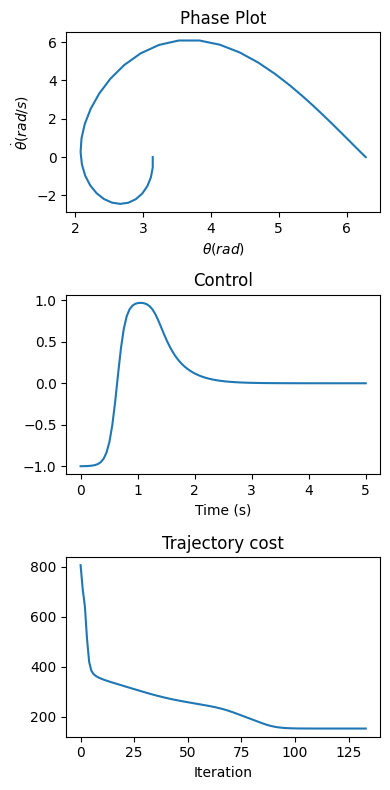

In [ ]:
import sympy as sym
import numpy as np
from time import time

with_plots = False
try:
    import matplotlib.pyplot as plt

    with_plots = True
except ImportError:
    print("ERROR: matplotlib not found. Skipping plots")

# dynamics parameters
G = 9.80665
M = 1.0
L = 1.0
dt = 0.05

# dynamics
def f(x, u, constrain=True):
    theta = sym.atan2(x[0], x[1])
    theta_dot = x[2]
    torque = sym.tanh(u[0]) if constrain else u[0]
    theta_dot_dot = -3 * G * sym.sin(theta + sym.pi) / (2 * L) + 3 * torque / (
        M * L**2
    )
    theta += theta_dot * dt
    theta_dot += theta_dot_dot * dt
    return sym.Matrix([sym.sin(theta), sym.cos(theta), theta_dot])


# instantenious cost
def g(x, u, x_goal):
    error = x - x_goal
    Q = np.array([[L**2, L, 0.0], [L, L**2, 0.0], [0.0, 0.0, 0.1]])
    R = np.array([[0.3]])
    result = error.T @ Q @ error + u.T @ R @ u
    return result


# termination cost
def h(x, x_goal):
    error = x - x_goal
    Qt = 100 * np.eye(3)
    result = error.T @ Qt @ error
    return result


# trajectory parameters
N = 100  # trajectory points
Nx = 3  # state dimension
Nu = 1  # control dimesions

# starting state
x0 = np.array([np.sin(np.pi), np.cos(np.pi), 0.0])

# goal state we want to reach
x_goal = np.array([np.sin(0.0), np.cos(0.0), 0.0])

print("Starting state", x0)
print("Goal state", x_goal)

# Create and run optimizer with random intialization
print("Starting optimization")
start_time = time()
ddp = DDPOptimizer(Nx, Nu, f, g, h)
X, U, X_hist, U_hist, J_hist = ddp.optimize(x0, x_goal, N=N, full_output=True)
print("Finished optimization in {:.2f}s".format(time() - start_time))

# plot results
if with_plots:
    print("Plotting results")

    fig, ax = plt.subplots(3, 1, figsize=(4, 8))
    tt = np.linspace(0, dt * N, N)
    theta_sol = np.unwrap(np.arctan2(X[:, 0], X[:, 1]))
    theta_dot_sol = X[:, 2]

    ax[0].plot(theta_sol, theta_dot_sol)
    ax[0].set_xlabel(r"$\theta (rad)$")
    ax[0].set_ylabel(r"$\dot{\theta} (rad/s)$")
    ax[0].set_title("Phase Plot")
    ax[1].set_title("Control")
    ax[1].plot(tt, np.tanh(U))
    ax[1].set_xlabel("Time (s)")
    ax[2].plot(J_hist)
    ax[2].set_title("Trajectory cost")
    ax[2].set_xlabel("Iteration")
    plt.tight_layout()